In [1]:
import os
import json
import pandas as pd
from moviepy.editor import *
from decord import VideoReader
import numpy as np
import math
from sklearn.metrics import f1_score

In [2]:
downsampling_rate= 1
def verify_frame_len(video_path, frame_idx):
    if video_path.endswith(".mp4"):
        video = VideoFileClip(video_path)
    else:
        video = VideoFileClip(video_path + ".mp4")
    n_frames = video.reader.nframes
    if n_frames // (downsampling_rate * video.fps) != max(frame_idx) + 1:
        print("ERROR", video.fps, n_frames, max(frame_idx))

In [3]:
def find_consecutive_timestamps(timestamps):
    """
    Function to find consecutive timestamps in a list and record the start and end time.
    """
    if not timestamps:
        return []

    # Initialize the first start time and the result list
    start = timestamps[0]
    result = []
    
    for i in range(1, len(timestamps)):
        # Check if the current timestamp is not consecutive
        if timestamps[i] != timestamps[i-1] + 1:
            # Record the previous consecutive sequence
            result.append([start, timestamps[i-1]])
            # Update the start for the new sequence
            start = timestamps[i]

    # Add the last sequence
    result.append([start, timestamps[-1]])

    return result

# Example usage
# timestamps = [0, 1, 2, 3, 4, 8, 10, 11, 12]
# find_consecutive_timestamps(timestamps)

In [4]:
def calculate_iou(ground_truth, predictions):
    """
    Calculate the Intersection over Union (IoU) for video moment retrieval.
    
    :param ground_truth: A tuple representing the ground truth interval (start, end).
    :param predictions: A list of tuples representing predicted intervals [(start1, end1), (start2, end2), ...].
    :return: IoU score.
    """
    GT_start, GT_end = ground_truth
    total_intersection = 0
    total_union = 0

    for (P_start, P_end) in predictions:
        # Calculate intersection
        intersection = max(0, min(GT_end, P_end) - max(GT_start, P_start))
        total_intersection += intersection

        # Calculate union for this predicted interval
        union = (P_end - P_start)  - intersection
        total_union += union
    total_union += (GT_end - GT_start)
    # Avoid division by zero
    if total_union == 0:
        return 0

    # Calculate IoU
    iou = total_intersection / total_union
    return iou

In [5]:
def save_json(content, save_path):
    with open(save_path, 'w') as f:
        f.write(json.dumps(content))
def load_jsonl(filename):
    with open(filename, "r") as f:
        return [json.loads(l.strip("\n")) for l in f.readlines()]
        # return json.loads(f)

In [6]:
#set folder path
root_path = "/home/hlpark/REDUCE/REDUCE_benchmarks/SeViLA/sevila_data/tvqa"
video_root = "/home/hlpark/shared/TVQA/video/video_files"
tvqa_result_32_root = "/home/hlpark/REDUCE/REDUCE_benchmarks/SeViLA/sevila_result_32_tvqa_val"
tvqa_result_full_root = "/home/hlpark/REDUCE/REDUCE_benchmarks/SeViLA/sevila_result_full_tvqa"
eval_path = "/home/hlpark/REDUCE/REDUCE_benchmarks/SeViLA/sevila_data/tvqa_evaluation_json"

vid_json_folder = "/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/splits/tvqa"
clip_pred_med = load_jsonl(f'{vid_json_folder}/five_labeled_pred_med_vid_dict.json')

In [7]:
# TVQA 32 frames from ground truth
tvqa_val_json = []
tvqa_list = []
video_list = []
target_list, pred_list = [], []
med_target, med_pred = [], []
nonmed_target, nonmed_pred = [], []
split = "val"
wrong_queries_32, correct_queries_32 = [], []
for _, dir, _ in os.walk(tvqa_result_32_root):
    for f in dir:
        tvqa_val_json.append(os.path.join(root_path, f + "_val_gt.json"))
        video_name = f
        video_list.append(os.path.join(video_root, video_name))
        if os.path.exists(os.path.join(tvqa_result_32_root, video_name, "result", "test_epochbest.json")) and split == "test":
            tvqa_list.append(os.path.join(tvqa_result_32_root, video_name, "result", "test_epochbest.json"))
        elif os.path.exists(os.path.join(tvqa_result_32_root, video_name, "result", "val_epochbest.json")) and split == "val":
            tvqa_list.append(os.path.join(tvqa_result_32_root, video_name, "result", "val_epochbest.json"))
        elif os.path.exists(os.path.join(tvqa_result_32_root, video_name, "result", "train_epochbest.json")) and split == "train":
            tvqa_list.append(os.path.join(tvqa_result_32_root, video_name, "result", "train_epochbest.json"))
            print("train file")
        else: 
            tvqa_list.append("")
assert len(tvqa_list) == len(tvqa_val_json)
al_json = {}
fileerr = 0
for idx, val_json in enumerate(tvqa_val_json):
    if tvqa_list[idx] == '':
        continue
    try:
        tvqa = load_jsonl(tvqa_list[idx])
        val = load_jsonl(val_json)
        tvqa_video = video_list[idx]
        
        
        for i, qa in enumerate(val[0]):
            dic = {}
            dic['ground_truth'] = [float(qa['start']), float(qa['end'])]
            dic['time_span_len'] = float(qa['end']) - float(qa['start'])
            dic['vid_name'] = qa['video']
            # if  math.isnan(dic['time_span_len']):
            #     print(float(qa['end']) , float(qa['start']), qa)
            dic['question'] = qa['question']
            al_json[qa['qid']] = dic

        max_frame_num = 0

        #remove duplicate queries in tvqa[0]
        seen_qid = []
        for qa in tvqa[0][:]:
            if qa['qid'] not in seen_qid:
                seen_qid.append(qa['qid'])
            else:
                tvqa[0].remove(qa)
                #print("remove duplicate ", qa['qid'])

        for i, qa in enumerate(tvqa[0]):
            max_frame_num = max(qa['frame_idx'])
            if qa['qid'] not in al_json:
                print("QID doesnt exist", qa['qid'])
            else:
                dic = al_json[qa['qid']] 
                #if dic['time_span_len'] == float(np.nan):
                    #print("nan")
                try:
                    pred = qa['frame_idx'][:int(np.ceil(dic['time_span_len']))]
                    pred = sorted(pred)
                    # print(pred)
                    pred_time_span = find_consecutive_timestamps(pred)
                    #print(dic['ground_truth'],pred_time_span)
                    dic['pred'] = pred_time_span
                    iou = calculate_iou(dic['ground_truth'], pred_time_span)
                    dic['iou'] = iou
                    
                    pred_list.append(qa['prediction'])
                    target_list.append(qa['target'])
                    #print(dic)
                    qa['question'] = dic['question']
                    qa['vid_name'] = dic['vid_name']
                    qa['time_span_len'] = dic['time_span_len']
                    qa['top4'] = qa['frame_idx'][:4]
                    qa['top4'] = qa['frame_idx'][:4]
                    qa['in_frames'] = [x for x in qa['frame_idx'][:4] if dic['ground_truth'][0] <= x <= dic['ground_truth'][1]]
                    qa['before_frames'] = [x for x in qa['frame_idx'][:4] if dic['ground_truth'][0] > x ]
                    qa['after_frames'] = [x for x in qa['frame_idx'][:4] if dic['ground_truth'][1] < x ]
                    if qa['prediction'] == qa['target']:
                        correct_queries_32.append(qa)
                    else:
                        wrong_queries_32.append(qa)

                    if clip_pred_med[0][dic['vid_name'] + ".mp4"] == "med":
                    #if "house" in dic['vid_name'] or "grey" in dic['vid_name']:
                        med_pred.append(qa['prediction'])
                        med_target.append(qa['target'])
                    else:
                        nonmed_pred.append(qa['prediction'])
                        nonmed_target.append(qa['target'])
                except ValueError:
                    #print(dic['time_span_len'])
                    print("ValueError ", qa['qid'], qa['frame_idx'])
                    dic['pred'] = [0, 0]
                    dic['iou'] = 0
                #uncomment this only when you want to check frame length for verification purpose
                #verify_frame_len(tvqa_video,  qa['frame_idx'])
                
                
                
    except FileNotFoundError as e: 
        print("file not found ", e)
        fileerr +=1
print("Number of processed queries: ", len(target_list))
print(f1_score(target_list, pred_list, average="micro"))
print(f1_score(target_list, pred_list, average="weighted"))
#print(len(med_target), len(med_pred), len(nonmed_target), len(nonmed_pred))
print(f1_score(med_target, med_pred, average="weighted"))

print(f1_score(nonmed_target, nonmed_pred, average="weighted"))


Number of processed queries:  15238
0.3190707441921512
0.306855626388957
0.2923304031222805
0.31027175256557615


In [8]:
# TVQA full video
tvqa_val_json = []
tvqa_list = []
video_list = []
target_list, pred_list = [], []
med_target, med_pred = [], []
nonmed_target, nonmed_pred = [], []
wrong_queries_full, correct_queries_full = [], []
split = "val"
in_count, out_count, only_before_count, only_after_count = 0, 0, 0, 0
for _, dir, _ in os.walk(tvqa_result_full_root):
    for f in dir:
        tvqa_val_json.append(os.path.join(root_path, f + "_val_gt.json"))
        video_name = f
        video_list.append(os.path.join(video_root, video_name))
        if os.path.exists(os.path.join(tvqa_result_full_root, video_name, "result", "test_epochbest.json")) and split == "test":
            tvqa_list.append(os.path.join(tvqa_result_full_root, video_name, "result", "test_epochbest.json"))
        elif os.path.exists(os.path.join(tvqa_result_full_root, video_name, "result", "val_epochbest.json")) and split == "val":
            tvqa_list.append(os.path.join(tvqa_result_full_root, video_name, "result", "val_epochbest.json"))
        elif os.path.exists(os.path.join(tvqa_result_full_root, video_name, "result", "train_epochbest.json")) and split == "train":
            tvqa_list.append(os.path.join(tvqa_result_full_root, video_name, "result", "train_epochbest.json"))
            print("train file")
        else: 
            tvqa_list.append("")
assert len(tvqa_list) == len(tvqa_val_json)
al_json = {}
fileerr = 0
for idx, val_json in enumerate(tvqa_val_json):
    if tvqa_list[idx] == '':
        continue
    try:
        tvqa = load_jsonl(tvqa_list[idx])
        val = load_jsonl(val_json)
        tvqa_video = video_list[idx]
        
        
        for i, qa in enumerate(val[0]):
            dic = {}
            dic['ground_truth'] = [float(qa['start']), float(qa['end'])]
            dic['time_span_len'] = float(qa['end']) - float(qa['start'])
            dic['vid_name'] = qa['video']
            dic['question'] = qa['question']
            # if  math.isnan(dic['time_span_len']):
            #     print(float(qa['end']) , float(qa['start']), qa)
            
            al_json[qa['qid']] = dic

        max_frame_num = 0

        #remove duplicate queries in tvqa[0]
        seen_qid = []
        for qa in tvqa[0][:]:
            if qa['qid'] not in seen_qid:
                seen_qid.append(qa['qid'])
            else:
                tvqa[0].remove(qa)
                #print("remove duplicate ", qa['qid'])
        for i, qa in enumerate(tvqa[0]):
            max_frame_num = max(qa['frame_idx'])
            if qa['qid'] not in al_json:
                print("QID doesnt exist", qa['qid'])
            else:
                dic = al_json[qa['qid']] 
                #if dic['time_span_len'] == float(np.nan):
                    #print("nan")
                try:
                    pred = qa['frame_idx'][:int(np.ceil(dic['time_span_len']))]
                    pred = sorted(pred)
                    # print(pred)
                    pred_time_span = find_consecutive_timestamps(pred)
                    #print(dic['ground_truth'],pred_time_span)
                    dic['pred'] = pred_time_span
                    iou = calculate_iou(dic['ground_truth'], pred_time_span)
                    dic['iou'] = iou
                    
                    pred_list.append(qa['prediction'])
                    target_list.append(qa['target'])
                    qa['question'] = dic['question']
                    qa['vid_name'] = dic['vid_name']
                    qa['time_span_len'] = dic['time_span_len']
                    qa['top4'] = qa['frame_idx'][:4]
                    qa['in_frames'] = [x for x in qa['frame_idx'][:4] if dic['ground_truth'][0] <= x <= dic['ground_truth'][1]]
                    qa['before_frames'] = [x for x in qa['frame_idx'][:4] if dic['ground_truth'][0] > x ]
                    qa['after_frames'] = [x for x in qa['frame_idx'][:4] if dic['ground_truth'][1] < x ]
                    if len(qa['in_frames']) > 0:
                        in_count += 1
                    if (len(qa['in_frames']) == 0) & ((len(qa['before_frames']) > 0) | (len(qa['after_frames']) > 0)):
                        out_count += 1
                    if qa['prediction'] == qa['target']:
                        correct_queries_full.append(qa)
                    else:
                        wrong_queries_full.append(qa)
                    if clip_pred_med[0][dic['vid_name'] + ".mp4"] == "med":
                    #if "house" in dic['vid_name'] or "grey" in dic['vid_name']:
                        med_pred.append(qa['prediction'])
                        med_target.append(qa['target'])
                    else:
                        nonmed_pred.append(qa['prediction'])
                        nonmed_target.append(qa['target'])
                except ValueError:
                    #print(dic['time_span_len'])
                    print("ValueError ", qa['qid'], qa['frame_idx'])
                    dic['pred'] = [0, 0]
                    dic['iou'] = 0
                #uncomment this only when you want to check frame length for verification purpose
                #verify_frame_len(tvqa_video,  qa['frame_idx'])
                
                
                
    except FileNotFoundError as e: 
        print("file not found ", e)
        fileerr +=1
print("Number of processed queries: ", len(target_list), in_count, out_count)
print(f1_score(target_list, pred_list, average="micro"))
print(f1_score(target_list, pred_list, average="weighted"))
#print(len(med_target), len(med_pred), len(nonmed_target), len(nonmed_pred))
print(f1_score(med_target, med_pred, average="weighted"))

print(f1_score(nonmed_target, nonmed_pred, average="weighted"))


ValueError  TVQA_999 [60, 11, 12, 10, 69, 42, 43, 13, 61, 59, 44, 27, 57, 45, 86, 25, 70, 41, 5, 56, 72, 26, 55, 14, 74, 84, 68, 67, 4, 32, 49, 40, 0, 48, 46, 71, 83, 73, 64, 2, 8, 3, 9, 47, 66, 58, 78, 29, 19, 28, 82, 65, 50, 1, 85, 24, 31, 7, 39, 16, 91, 15, 77, 76, 30, 75, 88, 81, 21, 90, 89, 20, 6, 87, 51, 33, 17, 36, 38, 53, 80, 52, 79, 34, 35, 37, 63, 62, 23, 54, 18, 22]
ValueError  TVQA_7285 [56, 61, 60, 62, 59, 48, 46, 57, 47, 44, 45, 54, 55, 58, 16, 49, 17, 50, 4, 3, 52, 18, 19, 2, 1, 53, 42, 51, 39, 41, 40, 43, 13, 0, 28, 5, 9, 6, 8, 36, 29, 12, 25, 15, 14, 24, 7, 31, 32, 30, 38, 27, 34, 23, 10, 33, 35, 11, 26, 21, 22, 20, 37]
ValueError  TVQA_12233 [7, 9, 11, 5, 32, 10, 13, 6, 14, 15, 8, 4, 12, 30, 31, 28, 19, 22, 29, 33, 21, 23, 20, 26, 25, 42, 44, 24, 34, 50, 27, 43, 3, 51, 41, 2, 52, 17, 57, 38, 16, 1, 39, 54, 18, 53, 45, 40, 56, 48, 55, 47, 35, 46, 49, 37, 36, 0]
ValueError  TVQA_5161 [24, 23, 20, 18, 19, 8, 2, 25, 35, 26, 22, 34, 21, 29, 12, 48, 51, 10, 36, 11, 15, 9, 5

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.tag.stanford import StanfordNERTagger
st = StanfordNERTagger('/home/hlpark/stanford-ner/english.all.3class.distsim.crf.ser.gz',
                       '/home/hlpark/stanford-ner/stanford-ner.jar')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
def tag(text):
    people = []
    for sent in nltk.sent_tokenize(text):
        tokens = nltk.tokenize.word_tokenize(sent)
        tags = st.tag(tokens)
        for tag in tags:
            if tag[1]=='PERSON': 
                people.append(tag)
    return people

KeyboardInterrupt: 

In [10]:
analysis_root = "/home/hlpark/REDUCE/REDUCE_benchmarks/SeViLA/sevila_data/analysis"
if not os.path.exists(os.path.join(analysis_root, "name.txt")):
    outputs = []
    correct_query_id_32 = [qa['qid'] for qa in correct_queries_32]
    for i, q in enumerate(wrong_queries_full): 
        if q['qid'] in correct_query_id_32:
            outputs.append(tag(q['question']))
    name_list = []
    for output in outputs:
        if len(output) > 1:
            for o in output:
                if o[1] == 'PERSON' and o[0] not in name_list:
                    name_list.append(o[0])
    with open(os.path.join(analysis_root, "name.txt"), "w") as f:
        for name in name_list:
            f.writelines(name + "\n")
else:
    name_list = []
    with open(os.path.join(analysis_root, "name.txt"), "r") as f:
        lines = f.read()
        for line in lines.split("\n"):
            name_list.append(line)
print(name_list)

['Beckett', 'Harris', 'Sorenson', 'Ricky', 'Connelly', 'Hayley', 'DuPre', 'Kopek', 'Ana', 'Castle', 'Kitty', 'Low', 'Stuckey', 'Esposito', 'Ryan', 'Kate', 'Marie', 'Montgomery', 'Marvin', 'Jimmy', 'Tommy', 'Brian', 'Seth', 'Alyssa', 'Hayes', 'David', 'Hernand', 'Raj', 'Bernadette', 'Oona', 'Martha', 'Hunt', 'Annabelle', 'Winters', 'Sam', 'McMurtry', 'Dolan', 'Dunne', 'Edmund', 'Twohey', 'Rob', 'McManus', 'Margo', 'Hannah', 'Penelope', 'Bob', 'Lockheart', 'Eric', 'Vance', 'Alexis', 'Lyle', 'Patrice', 'Nieman', 'Pam', 'Tori', 'Anderson', 'Cross', 'Sheldon', 'Matilda', 'Eddie', 'Justin', 'Smith', 'Philip', 'Dagmar', 'Luca', 'Naziff', 'Nazif', 'Scott', 'Robert', 'Amy', 'Lopez', 'Derek', 'Pitbull', 'Hyde', 'Mia', 'Sergei', 'Mason', 'Wood', 'Dave', 'Gabriel', 'Rollins', 'Rachel', 'hope', 'Monica', 'Ross', 'Joey', 'Chandler', 'Pheobe', 'Susan', 'Luisa', 'Phoebe', 'Stephanie', 'Buffay', 'Karen', 'Greene', 'Gunther', 'Rhodes', 'Doug', 'Sr.', 'joey', 'think', 'chandler', 'Rick', 'Frank', 'Alice'

In [11]:
def df_transform(gt_list):
    interval = 5
    start, last = 5, 50
    df = pd.DataFrame(gt_list, columns=['gt_time'])
    df['gt_time_transform'] = -1
    for length in range(start, last, interval):
        df.loc[(df['gt_time'] < length) & (df['gt_time'] >= length - interval), 'gt_time_transform'] = length
    df.loc[(df['gt_time'] >= last), 'gt_time_transform'] = last
    new_df = df.groupby('gt_time_transform').count().reset_index().rename(columns={'gt_time' : 'count'})
    print(new_df.head())
    return new_df

def FWOH_distribution(queries):
    df = pd.DataFrame(queries, columns=['queries'])
    df['FWOH'] = "Other"
    df.loc[df['queries'].str.lower().str.startswith("what"), 'FWOH'] = "What"
    df.loc[df['queries'].str.lower().str.startswith("why"), 'FWOH'] = "Why"
    df.loc[df['queries'].str.lower().str.startswith("who"), 'FWOH'] = "Who"
    df.loc[df['queries'].str.lower().str.startswith("where"), 'FWOH'] = "Where"
    df.loc[df['queries'].str.lower().str.startswith("when"), 'FWOH'] = "When"
    df.loc[df['queries'].str.lower().str.startswith("how"), 'FWOH'] = "How"
    new_df = df.groupby('FWOH').count().reset_index().rename(columns={'queries' : 'count'})
    print(new_df.head())
    return new_df

def count_relationship(query_list):
    cnt = 0
    for q in query_list.split("\n"):
        if "after" in q or "before" in q:
            cnt += 1
    print(cnt)

Wrong in full video, correct in ground truth clipped video
Total  885
Med total  157 0.17740112994350282
454 417 587 279
   gt_time_transform  count
0                 -1      3
1                  5    218
2                 10    410
3                 15    126
4                 20     51
    FWOH  count
0    How     70
1  Other     10
2   What    492
3   When      5
4  Where    117
344


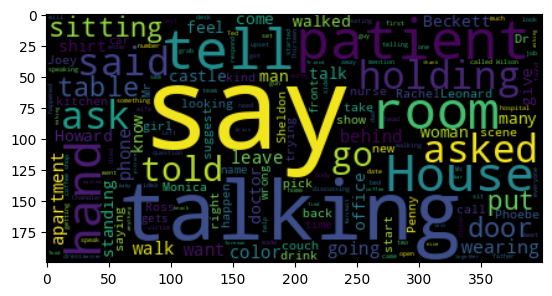

In [12]:

wf_c32 = "wf_c32.txt"
lines = ""
timespan, fwoh = [], []
with open(os.path.join(analysis_root, wf_c32), "w") as f:
    correct_query_id_32 = [qa['qid'] for qa in correct_queries_32]
    count = 0
    med_count = 0
    in_count, before_count, after_count, all_count = 0, 0, 0, 0
    for i, q in enumerate(wrong_queries_full): 
        if q['qid'] in correct_query_id_32:
            count += 1
            # if "house" in q['vid_name'] or "grey" in q['vid_name']:
            if clip_pred_med[0][q['vid_name'] + ".mp4"] == "med":
                med_count += 1
            timespan.append(q['time_span_len'])
            fwoh.append(q['question'])
            if len(q['in_frames']) > 0:
                in_count += 1
            if len(q['before_frames']) > 0:
                before_count += 1
            if len(q['after_frames']) > 0:
                after_count += 1
            
            if (len(q['in_frames']) > 0) & (len(q['after_frames']) > 0):
                all_count += 1
            # get rid of name
            line = ""
            for word in q['question'].split(" "):
                if word not in name_list:
                    line += word + " "
            lines += line + "\n"
            f.writelines(q['question'] + "\n")
    print("Wrong in full video, correct in ground truth clipped video")
    print("Total ", count)
    print("Med total ", med_count, med_count / count)
    print(in_count, before_count, after_count, all_count)
wf_c32_df = df_transform(timespan)
wf_c32_fwoh_df = FWOH_distribution(fwoh)
count_relationship(lines)
wc = WordCloud().generate(lines)
plt.imshow(wc, interpolation='bilinear')
plt.show()

Correct in full video, wrong in ground truth clipped video
Total  1765
Medical total  322 0.18243626062322946
   gt_time_transform  count
0                 -1     15
1                  5    427
2                 10    806
3                 15    229
4                 20    111
    FWOH  count
0    How    140
1  Other     16
2   What   1070
3   When     10
4  Where    232
648


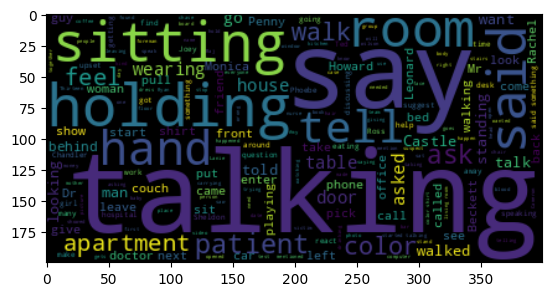

In [14]:
correct_query_id_full = [qa['qid'] for qa in correct_queries_full]
count = 0
med_count = 0
cf_w32 = "cf_w32.txt"
lines = ""
timespan, fwoh = [], []
with open(os.path.join(analysis_root, cf_w32), "w") as f:
    for i, q in enumerate(wrong_queries_32): 
        if q['qid'] in correct_query_id_full:
            count += 1
            # if "house" in q['vid_name'] or "grey" in q['vid_name']:
            if clip_pred_med[0][q['vid_name'] + ".mp4"] == "med":
                med_count += 1
            timespan.append(q['time_span_len'])
            fwoh.append(q['question'])
            # get rid of name
            line = ""
            for word in q['question'].split(" "):
                if word not in name_list:
                    line += word + " "
            lines += line + "\n"
            f.writelines(q['question'] + "\n")
    print("Correct in full video, wrong in ground truth clipped video")
    print("Total ", count)
    print("Medical total ", med_count, med_count / count)
cf_w32_df = df_transform(timespan)
cf_w32_fwoh_df = FWOH_distribution(fwoh)
count_relationship(lines)
wc = WordCloud().generate(lines)
plt.imshow(wc, interpolation='bilinear')
plt.show()

Correct in full video, correct in ground truth clipped video
Total  3848
Medical total  672 0.17463617463617465
   gt_time_transform  count
0                 -1     33
1                  5    921
2                 10   1719
3                 15    544
4                 20    237
    FWOH  count
0    How    336
1  Other     39
2   What   2297
3   When     13
4  Where    517


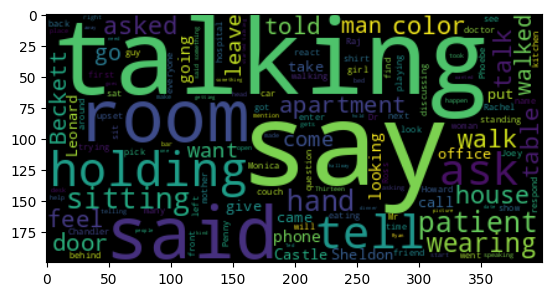

In [128]:
correct_query_id_32 = [qa['qid'] for qa in correct_queries_32]
count = 0
med_count = 0
cf_c32 = "cf_c32.txt"
lines = ""
timespan, fwoh = [], []

with open(os.path.join(analysis_root, cf_c32), "w") as f:
    for i, q in enumerate(correct_queries_full): 
        if q['qid'] in correct_query_id_32:
            count += 1
            # if "house" in q['vid_name'] or "grey" in q['vid_name']:
            if clip_pred_med[0][q['vid_name'] + ".mp4"] == "med":
                med_count += 1
            timespan.append(q['time_span_len'])
            fwoh.append(q['question'])
            # get rid of name
            line = ""
            for word in q['question'].split(" "):
                if word not in name_list:
                    line += word + " "
            lines += line + "\n"
            f.writelines(q['question'] + "\n")
    print("Correct in full video, correct in ground truth clipped video")
    print("Total ", count)
    print("Medical total ", med_count, med_count / count)
cf_c32_df = df_transform(timespan)
cf_c32_fwoh_df = FWOH_distribution(fwoh)
wc = WordCloud().generate(lines)
plt.imshow(wc, interpolation='bilinear')
plt.show()

Wrong in full video, wrong in ground truth clipped video
Total  8363
Medical total  1537 0.18378572282673683
   gt_time_transform  count
0                 -1     61
1                  5   1928
2                 10   3544
3                 15   1318
4                 20    578
    FWOH  count
0    How    796
1  Other    100
2   What   4423
3   When     69
4  Where    853


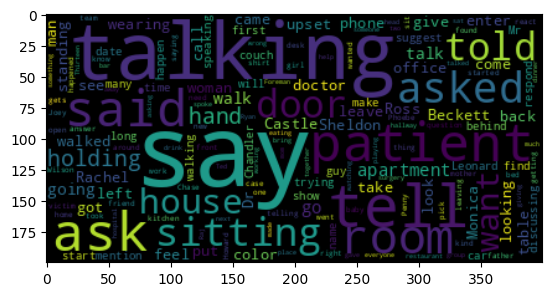

In [129]:
wrong_query_id_32 = [qa['qid'] for qa in wrong_queries_32]
count = 0
med_count = 0
wf_w32 = "wf_w32.txt"
lines = ""
timespan, fwoh = [], []

with open(os.path.join(analysis_root, wf_w32), "w") as f:
    for i, q in enumerate(wrong_queries_full): 
        if q['qid'] in wrong_query_id_32:
            count += 1
            # if "house" in q['vid_name'] or "grey" in q['vid_name']:
            if clip_pred_med[0][q['vid_name'] + ".mp4"] == "med":
                med_count += 1
            timespan.append(q['time_span_len'])
            fwoh.append(q['question'])
            # get rid of name
            line = ""
            for word in q['question'].split(" "):
                if word not in name_list:
                    line += word + " "
            lines += line + "\n"
            f.writelines(q['question'] + "\n")
    print("Wrong in full video, wrong in ground truth clipped video")
    print("Total ", count)
    print("Medical total ", med_count, med_count / count)
wf_w32_df = df_transform(timespan)
wf_w32_fwoh_df = FWOH_distribution(fwoh)
wc = WordCloud().generate(lines)
plt.imshow(wc, interpolation='bilinear')
plt.show()

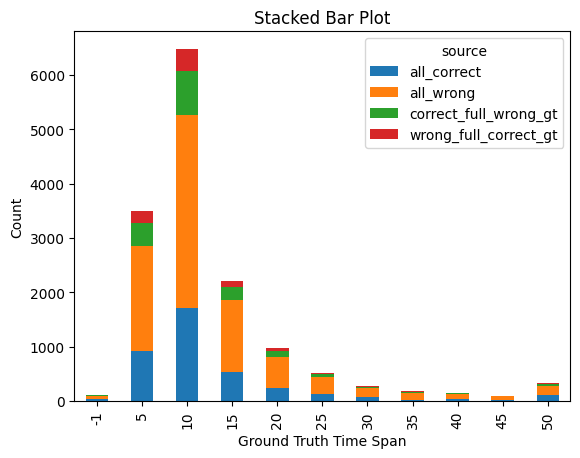

In [119]:
cf_w32_df['source'] = "correct_full_wrong_gt"
wf_c32_df['source'] = "wrong_full_correct_gt"
cf_c32_df['source'] = "all_correct"
wf_w32_df['source'] = "all_wrong"

combined_df = pd.concat([cf_w32_df, wf_c32_df, cf_c32_df, wf_w32_df])
pivot_df = combined_df.pivot_table(index='gt_time_transform', columns='source', values='count', fill_value=0)
pivot_df.plot(kind='bar', stacked=True)
plt.xlabel('Ground Truth Time Span')
plt.ylabel('Count')
plt.title('Stacked Bar Plot')
plt.show()

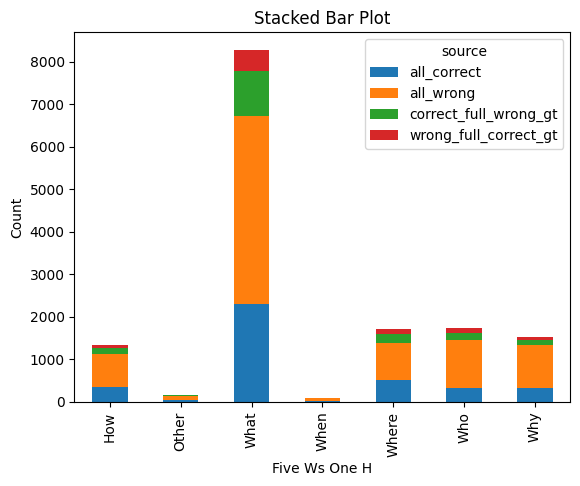

In [130]:
cf_w32_fwoh_df['source'] = "correct_full_wrong_gt"
wf_c32_fwoh_df['source'] = "wrong_full_correct_gt"
cf_c32_fwoh_df['source'] = "all_correct"
wf_w32_fwoh_df['source'] = "all_wrong"

combined_df = pd.concat([cf_w32_fwoh_df, wf_c32_fwoh_df, cf_c32_fwoh_df, wf_w32_fwoh_df])
pivot_df = combined_df.pivot_table(index='FWOH', columns='source', values='count', fill_value=0)
pivot_df.plot(kind='bar', stacked=True)
plt.xlabel('Five Ws One H')
plt.ylabel('Count')
plt.title('Stacked Bar Plot')
plt.show()

In [10]:
train_path = f'{eval_path}/train.json'
val_path = f'{eval_path}/val.json'
test_path = f'{eval_path}/test.json'
train = load_jsonl(train_path)
val = load_jsonl(val_path)
test = load_jsonl(test_path)

In [13]:
val = load_jsonl(val_path)
print(len(val))

15253


In [ ]:
val_total_cnt = 0
test_total_cnt = 0
val_dict = {}
for i, qa in enumerate(val[0]):
    val_total_cnt +=1
    val_dict[str(qa['qid'])] = 1
print(idx)
train_dict = {}
for i, qa in enumerate(train[0]):
    train_dict[str(qa['qid'])] = 1
test_dict = {}
for i, qa in enumerate(test[0]):
    test_total_cnt += 1
    test_dict[str(qa['qid'])] = 1

4357


In [ ]:
val_cnt, train_cnt, test_cnt = 0, 0, 0
cnt_3_thresh, cnt_5_thresh, cnt_7_thresh = 0, 0, 0
med_cnt_3_thresh, med_cnt_5_thresh, med_cnt_7_thresh = 0, 0, 0
nonmed_cnt_3_thresh, nonmed_cnt_5_thresh, nonmed_cnt_7_thresh = 0, 0, 0
med_cnt, nonmed_cnt = 0, 0
for key, val in al_json.items():
    if 'iou' not in val:
        continue
    #print(key)
    if key in val_dict:
        val_cnt += 1
        # if "house" in val['vid_name'] or "grey" in val['vid_name']:
        if clip_pred_med[0][val['vid_name'] + ".mp4"] == "med":
            med_cnt += 1
            if val['iou'] > 0.3:
                med_cnt_3_thresh += 1
            if val['iou'] > 0.5:
                med_cnt_5_thresh += 1
            if val['iou'] > 0.7:
                med_cnt_7_thresh += 1
        else:
            nonmed_cnt += 1
            if val['iou'] > 0.3:
                nonmed_cnt_3_thresh += 1
            if val['iou'] > 0.5:
                nonmed_cnt_5_thresh += 1
            if val['iou'] > 0.7:
                nonmed_cnt_7_thresh += 1
        if val['iou'] > 0.3:
            cnt_3_thresh += 1
        if val['iou'] > 0.5:
            cnt_5_thresh += 1
        if val['iou'] > 0.7:
            cnt_7_thresh += 1
        
if val_cnt > 0:
    # assert len(val_dict) == val_cnt
    print(f"VAL IoU=0.3: {cnt_3_thresh/(val_cnt) * 100}\nIoU=0.5: {cnt_5_thresh/(val_cnt) * 100}\nIoU=0.7: {cnt_7_thresh/(val_cnt) * 100}\ntotal queries:{(val_cnt)}/{val_total_cnt}")
    print(f"\nVAL Medical IoU=0.3: {med_cnt_3_thresh/(med_cnt) * 100}\nIoU=0.5: {med_cnt_5_thresh/(med_cnt) * 100}\nIoU=0.7: {med_cnt_7_thresh/(med_cnt) * 100}\ntotal queries:{(med_cnt)}/{val_total_cnt}")
    print(f"\nVAL Non-medical IoU=0.3: {nonmed_cnt_3_thresh/(nonmed_cnt) * 100}\nIoU=0.5: {nonmed_cnt_5_thresh/(nonmed_cnt) * 100}\nIoU=0.7: {nonmed_cnt_7_thresh/(nonmed_cnt) * 100}\ntotal queries:{(nonmed_cnt)}/{val_total_cnt}")

cnt_3_thresh, cnt_5_thresh, cnt_7_thresh = 0, 0, 0
med_cnt_3_thresh, med_cnt_5_thresh, med_cnt_7_thresh = 0, 0, 0
nonmed_cnt_3_thresh, nonmed_cnt_5_thresh, nonmed_cnt_7_thresh = 0, 0, 0
med_cnt, nonmed_cnt = 0, 0
for key, val in al_json.items():
    if 'iou' not in val:
        continue
    #print(key)
    if key in test_dict:
        test_cnt += 1
        # if "house" in val['vid_name'] or "grey" in val['vid_name']:
        if clip_pred_med[0][val['vid_name'] + ".mp4"] == "med":
            med_cnt += 1
            if val['iou'] > 0.3:
                med_cnt_3_thresh += 1
            if val['iou'] > 0.5:
                med_cnt_5_thresh += 1
            if val['iou'] > 0.7:
                med_cnt_7_thresh += 1
        else:
            nonmed_cnt += 1
            if val['iou'] > 0.3:
                nonmed_cnt_3_thresh += 1
            if val['iou'] > 0.5:
                nonmed_cnt_5_thresh += 1
            if val['iou'] > 0.7:
                nonmed_cnt_7_thresh += 1
        if val['iou'] > 0.3:
            cnt_3_thresh += 1
        if val['iou'] > 0.5:
            cnt_5_thresh += 1
        if val['iou'] > 0.7:
            cnt_7_thresh += 1
        
if test_cnt > 0:
    # assert len(val_dict) == val_cnt
    print(f"TEST IoU=0.3: {cnt_3_thresh/(test_cnt) * 100}\nIoU=0.5: {cnt_5_thresh/(test_cnt) * 100}\nIoU=0.7: {cnt_7_thresh/(test_cnt) * 100}\ntotal queries:{(test_cnt)}/{test_total_cnt}")
    print(f"\nTEST Medical IoU=0.3: {med_cnt_3_thresh/(med_cnt) * 100}\nIoU=0.5: {med_cnt_5_thresh/(med_cnt) * 100}\nIoU=0.7: {med_cnt_7_thresh/(med_cnt) * 100}\ntotal queries:{(med_cnt)}/{test_total_cnt}")
    print(f"\nTEST Non-medical IoU=0.3: {nonmed_cnt_3_thresh/(nonmed_cnt) * 100}\nIoU=0.5: {nonmed_cnt_5_thresh/(nonmed_cnt) * 100}\nIoU=0.7: {nonmed_cnt_7_thresh/(nonmed_cnt) * 100}\ntotal queries:{(nonmed_cnt)}/{test_total_cnt}")


VAL IoU=0.3: 18.1109243697479
IoU=0.5: 7.8924369747899155
IoU=0.7: 3.1731092436974793
total queries:14875/15253

VAL Medical IoU=0.3: 13.504464285714285
IoU=0.5: 5.059523809523809
IoU=0.7: 1.7857142857142856
total queries:2688/15253

VAL Non-medical IoU=0.3: 19.126938541068352
IoU=0.5: 8.517272503487321
IoU=0.7: 3.479117091983261
total queries:12187/15253
TEST IoU=0.3: 17.927321668909826
IoU=0.5: 7.806191117092867
IoU=0.7: 3.0148048452220726
total queries:7430/7623

TEST Medical IoU=0.3: 13.612565445026178
IoU=0.5: 5.310396409872849
IoU=0.7: 1.795063575168287
total queries:1337/7623

TEST Non-medical IoU=0.3: 18.87411784014443
IoU=0.5: 8.353848678811751
IoU=0.7: 3.282455276546857
total queries:6093/7623
